# Quantum Process Tomography using the KLM CNOT Gate in Perceval

In [1]:
import perceval as pcvl
import numpy as np
from perceval.components import catalog
from perceval.components.source import Source
from perceval.algorithm import ProcessTomography
from perceval.algorithm.tomography import is_physical

#### Displaying the Heralded (KLM protocol) CNOT gate and its truth table

,00,01,10,11
00,0.999983,1.65529e-05,0,0
01,1.65529e-05,0.999983,0,0
10,0,0,8.01472e-06,0.999992
11,0,0,0.999992,8.01472e-06


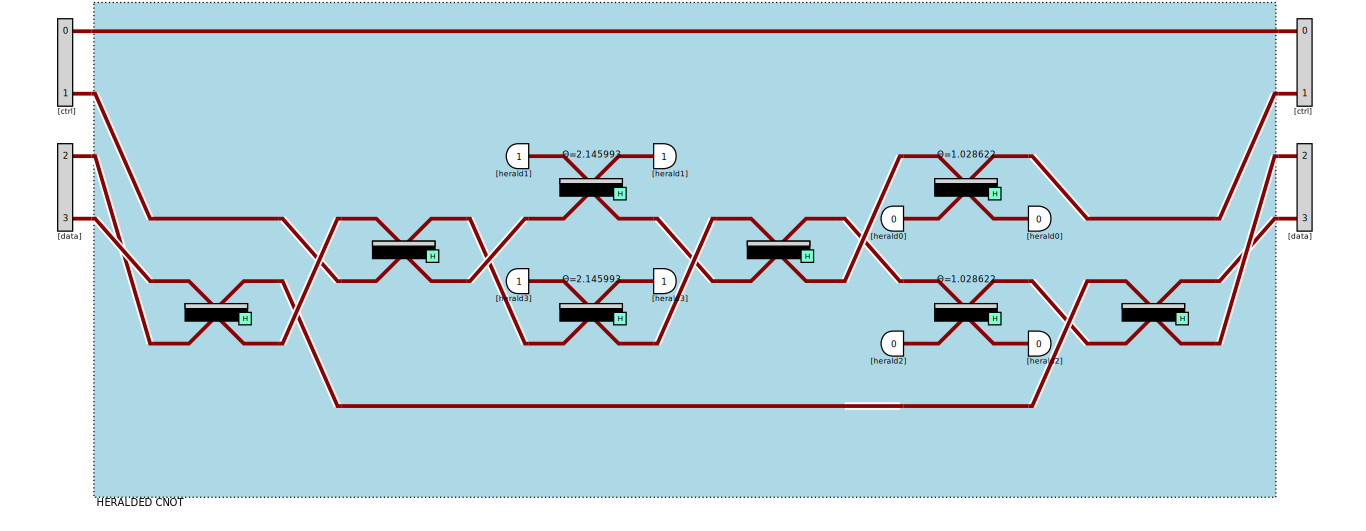

In [2]:
cnot = catalog["klm cnot"].build_processor()

states = {
    pcvl.BasicState([1,0,1,0]): "00",
    pcvl.BasicState([1,0,0,1]): "01",
    pcvl.BasicState([0,1,1,0]): "10",
    pcvl.BasicState([0,1,0,1]): "11"
}
ca = pcvl.algorithm.Analyzer(cnot,states)
pcvl.pdisplay(ca)
pcvl.pdisplay(cnot, recursive=True)

## Quantum Process Tomography
Quantum Process Tomography (QPT) is a tool to reconstruct the mathematical operation associated to a physical gate by a series of different measurements of different inputs. QPT scales exponentially with the number of qubits. Any quantum channel (completely positive quantum operation) has a χ matrix representation : $$\varepsilon(\rho)=\sum_{m,n}\chi_{mn}E_m\rho E_n^{\dag}$$QPT reconstructs the χ matrix. It needs to precise the number of qubits and the heralded modes with the number of photons on them.

To perform this in perceval, create a processor (klm cnot in this case) with setting heralds manually and initialize a $QuantumProcessTomography$ object.
Note: Heralding is removed by default when performing a tomography.

/Users/raksha/simulations/perceval/perceval/rendering/pdisplay.py:301: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


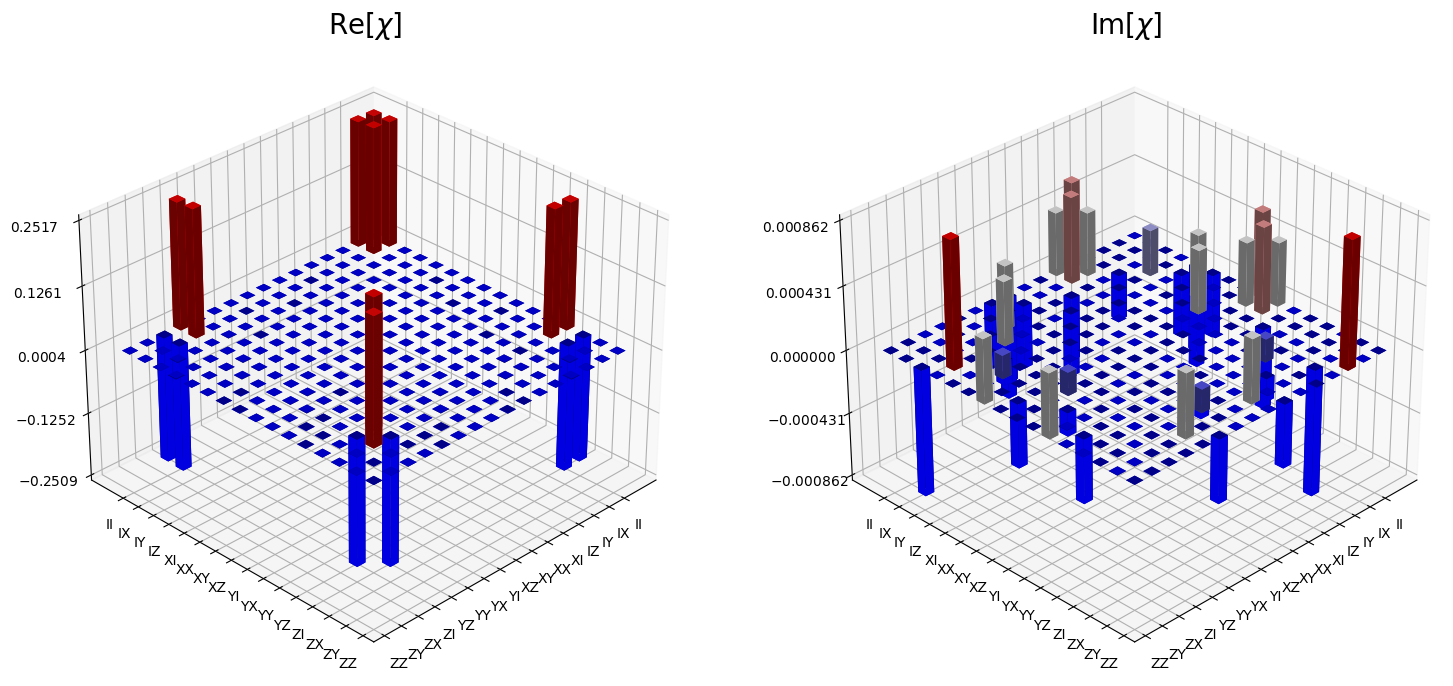

TypeError: 'Figure' object is not subscriptable

In [3]:
qpt = ProcessTomography(nqubit=2, operator_processor=cnot)
chi_op = qpt.chi_matrix()  # computing the chi matrix
pcvl.pdisplay(qpt)  # visualization of the same chi

## Process Fidelity Computations

Once having the χ matrix, it might be useful to know how close the heralded gate is to the real CNOT operation. We can compute the process fidelity $$F_{\chi}= Tr({\chi}_{ideal} {\chi}_{physical})$$.

In [4]:
# checking fidelity
op_CX = np.array([[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 0, 1],
             [0, 0, 1, 0]], dtype='complex_')

chi_op_ideal = qpt.chi_target(op_CX)
cnot_fidelity = qpt.process_fidelity(chi_op, chi_op_ideal)
print("Process Fidelity of CNOT gate operation", cnot_fidelity)

Process Fidelity of CNOT gate operation 0.9996768908702185


As expected, the fidelity is close to one. The gate behaves as we want. However, we can see that it is not exactly 1, while we are in the ideal case. This is because when reconstructing the probabilities of each outcome, we are postselecting on the fact that we get a logical ouput. We then consider some information we do not want. We can overturn this by renormalizing by the success probability of the gate on every outcome uniformly.

### Using Renormalization to improve Fidelity

In [5]:
prob_succ = (0.051564+0.051436)/2
qpt_renorm = ProcessTomography(nqubit=2, operator_processor=cnot, renormalization=prob_succ)
chi_op_renorm = qpt_renorm.chi_matrix()  # computing the chi matrix

f_chi_renorm = qpt_renorm.process_fidelity(chi_op_renorm, chi_op_ideal)
print("Process fidelity with renormalization :",f_chi_renorm)

Process fidelity with renormalization : 0.9999921568471093


Clearly the fidelity improves depending on the renormalization. Now how did we choose this renormalization factor - $prob\_succ$ ?
Ans: On the basis of the output distribution obtained from perceval without any heralding (achieved by building the cnot gate as a circuit). [See next cell]

In [6]:
h_cnot_circ=catalog["klm cnot"].build_circuit()

p=pcvl.Processor("Naive",h_cnot_circ)
states = {
    pcvl.BasicState([1,0,1,0,0,1,0,1]): "00",
    pcvl.BasicState([1,0,0,1,0,1,0,1]): "01",
    pcvl.BasicState([0,1,1,0,0,1,0,1]): "10",
    pcvl.BasicState([0,1,0,1,0,1,0,1]): "11"
}
ca = pcvl.algorithm.Analyzer(p,states)
pcvl.pdisplay(ca)

,00,01,10,11
00,0.051564,0,0,0
01,0,0.051564,0,0
10,0,0,0,0.051436
11,0,0,0.051436,0


## Average fidelity
Computing the process fidelity can be quite long because we are manipulating matrices that scale exponentially with the number of qubits. If we are only interested in the fidelity of the gate, we can compute its average fidelity : $$\bar{F}= \frac{1}{d+1}+\frac{1}{d^2(d+1)}\sum_j Tr(U E_j^\dag U^\dag \varepsilon(E_j))$$

In [7]:
f_avg = qpt.average_fidelity(op_CX)
print("average fidelity :",f_avg)

average fidelity : 0.9997415126961746


## Physicality of the maps

When we reconstruct a process map, an important question is to know whether it is physical or not. A map is called physical if it is trace-preserving (TP), Hermitian, and completely positive (CP).

A map is TP if its $\chi$ matrix is trace 1. To check the CP part is a bit more difficult: The general algorithm (for finite dimensions is using the Choi-Jamiolkowski-isomorphism.

A map $\epsilon$ is CP iff the Choi matrix
$$S:=(\varepsilon \otimes I_d)(\ket{\Omega}\bra{\Omega})$$
is a positive semidefinite matrix, where ∣Ω⟩=∑i=1d​∣ii⟩ is the maximally entangled state.

Let's check first that the ideal heralded CNOT is physical.

In [8]:
print('Results from testing the physicality of the Chi matrix for the CNOT gate operation')
print(is_physical(chi_op, 2))

print('Results from testing the physicality of the Chi matrix for the CNOT gate operation after renormalization (as above)')
print(is_physical(chi_op_renorm, 2))

Results from testing the physicality of the Chi matrix for the CNOT gate operation
['|trace 1|', '|hermitian|', '|not Completely Positive|smallest eigenvalue :-0.00214']
Results from testing the physicality of the Chi matrix for the CNOT gate operation after renormalization (as above)
['|trace 1|', '|hermitian|', '|Completely Positive|']


## Error Process Map

A nice way to highlight the errors in the computation is to look at the error process map. $$\chi_{err}=V \chi V^†$$

$$V_{mn} = \frac{Tr(E_m^† E_n U^†)}{d}$$ The upper left coefficient is the process fidelity while all the other non-zero coefficients represent some kind of errors. For example, non-zero imaginary coefficients on the first row (or first column) represent first-order unitary errors. Non-zero diagonal coefficients represent Pauli errors.

In [9]:
# Error map for an operation with an imperfect source with properties g2=0.00732, indistinguishability=0.9438
src = Source(multiphoton_component=0.00732, indistinguishability=0.9438)
cnot_imperfect_src = catalog["klm cnot"].build_processor()
cnot_imperfect_src.source = src

qpt_imperfect_source = ProcessTomography(nqubit=2, operator_processor=cnot_imperfect_src)
chi_op_imperfect_src = qpt_imperfect_source.chi_matrix()  # computing the chi matrix

U=qpt.error_process_matrix(chi_op_imperfect_src, op_CX)

# many values too small in U, filtering them out
U = np.where(abs(U)<1e-6, 0, U)
print(U)

[[ 8.82787437e-01+1.92785791e-17j  5.11469330e-03-9.16909181e-17j
   2.98072010e-06+2.15105711e-16j  0.00000000e+00+0.00000000e+00j
  -7.14129207e-05-1.20928599e-03j -1.32504139e-04-2.10547170e-03j
   0.00000000e+00+0.00000000e+00j -8.72001986e-07-1.47386867e-06j
  -7.14129207e-05+1.20928599e-03j -1.32504139e-04+2.10547170e-03j
   0.00000000e+00+0.00000000e+00j  8.72001987e-07-1.47386867e-06j
   8.21696430e-03+6.07028859e-17j  1.05780841e-02+7.66080348e-17j
  -1.10203174e-06-2.28983499e-16j  0.00000000e+00+0.00000000e+00j]
 [ 5.11469330e-03-5.89285720e-17j  1.77608402e-02+1.04953589e-16j
   0.00000000e+00+0.00000000e+00j -1.24900090e-16-2.98072010e-06j
  -8.25111258e-05-1.22467679e-03j -7.14129207e-05-1.20928599e-03j
   1.47386867e-06-8.72001987e-07j  0.00000000e+00+0.00000000e+00j
  -8.25111258e-05+1.22467679e-03j -7.14129207e-05+1.20928599e-03j
   1.47386867e-06+8.72001986e-07j  0.00000000e+00+0.00000000e+00j
  -6.78900934e-03+1.17123545e-16j  7.33733509e-03-4.05873289e-17j
   0.0000

# Todo : improve documentation above, and write things coherently. They are directly copied from Arman's notebook made for internal discussions

/var/folders/gs/x_z7jfz50cl8mlmt_sblltz40000gp/T/ipykernel_70994/144632543.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(abs(U)))


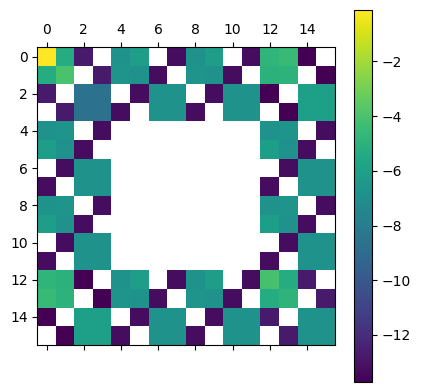

In [10]:
import matplotlib.pyplot as plt
plt.matshow(np.log(abs(U)))
plt.colorbar()
plt.show()